<center> Bruno Luvizotto Carli </center>
<p style="text-align:center;"> Universidade Federal do Paraná </p>
<p style="text-align:right;"> 2021 </p>

<br />
<hr />
<br />

<h3> Introdução </h3>

<p style="text-align:justify;">
O presente artigo pretende investigar os resultados da aplicação de técnicas depré-processamento de dados sob uma base de dados de fonte pública. O tema escolhido foi Infecções confirmadas por Covid-19 no Município de Curitiba.A prefeitura disponibiliza uma base de dados Oliveira (2021),de casos confirmados da doença, de onde se pretende extrair os dados, identificar uma variável preditora, aplicar um modelo de machine learning e identificar os resultados de melhoria que as técnicas de escalonamento e padronização dos dados na fase de pré-processamento podem propiciar ao modelo.
</p>

<br />

<h3> Trabalhos relacionados </h3>

<p style="text-align:justify;">
    Rizatti <i>et al</i>. (2020) realizaram um mapeamento da pandemia em Santa Maria/RS ao qual apresentou ideias enaltecedoras na resolução da visualização do nível de infecção nas zonas urbanas da cidade, motivação suficiente para buscar a geolocalização dos distritos utilizados na base de dados deste trabalho a fim de promover uma ilustração semelhante par aa cidade de Curitiba.
</p>

<p style="text-align:justify;">
Porém a essência da proposta deste trabalho somente pode se desenrolar sob a luz iluminadora de Guizelini et al. (2020) cujo foi a maçã de newton para este estudo, possibilitando revelar a variável preditora escondida como agulha no palheiro dos dados escolhidos para o estudo. Guizelini et al. (2020) do Laboratório de Inteligência Artificial Aplicada a Bioinformática (AIBIA) da Universidade Federal do Paraná (UFPR) utilizaram algoritmos para prever as <b>médias móveis</b> de casos de infecção por Covid no territorio nacional. Estes, justificam a usabilidade dos dados escolhidos, cujos apresentaram grande resiliência à análise, cabendo ao pesquisador desbobrar os dados para a extração da informação que será utilizada como combustível dos algoritmos de machine learning e consequentemente, ilustrar a porposta deste trabalho: avaliar a influência da padronização e escalonamento dos dados sob o resultado da previsão do modelo.
</p>


### Bibliotecas utilizadas

In [254]:
from collections import Counter
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import plot_confusion_matrix

### Metodologia

<p style="text-align:justify;">
Conforme Harrison (2020) "O CRISP-DM (Cross-Industry Standard Process for Data Mining ou processo para fazer mineração de dados (data mining), o qual contém vários passos que podem ser seguidos para uma melhoria contínua" elencando-os:
</p>

- Entendimento do negócio;
- Entendimento dos dados;
- Preparação dos dados;
- Modelagem;
- Avaliação;
- Implantação.

<p style="text-align:justify;">
Para fins deste estudo vamos apenas focar nas fases de entendimento e preparação dos dados, modelagem e avaliação do modelo. Após a limpeza inicial será calculado com base nas datas de ocorrência as médias móveis para número de infectados e para o número de óbitos. A partir desta informação utilizarse-a de modelos de regrassão para estimar os valores futuros para infectados e óbitos. Salienta-se aqui que o objetivo do estudo em si, não é prever com eficiência e precisão os dados futuros, mas sim observar o impacto do pré-processamento, comparado os resultados das regressões sob modelos treinados nos dados brutos e modelos trinados sob dados escalonados e padronizados.
</p>

### Base de dados

<p style="text-align:justify;">
    A base de dados utilizada foi a <b>Casos de COVID-19 em Curitiba</b> Oliveira (2021), cuja possui 234125 instâncias para 7 colunas de características, das quais descreve-se a data de notificação, idade, gênero, região sanitária (bairro), data de óbito (se em caso de óbito) e estado do indivíduo (se recuperado ou óbito). Todos as ocorrências são casos em que a doença foi confirmada.
</p>

<br />

In [2]:
# this works on my mac
df = pd.read_csv('2021-06-24_Casos_Covid_19_-_Base_de_Dados.csv', sep=';')
df.columns = ['notification_date', 'class', 'age',
              'gender', 'district', 'death_date', 'status', '_']
df.drop(columns='_', inplace=True)

# This works on my linux
# df = pd.read_csv('2021-07-01_Casos_Covid_19_-_Base_de_Dados.csv', sep=',', encoding='UTF-8')
# df.columns = ['notification_date', 'class', 'age',
#               'gender', 'district', 'death_date', 'status']

# lol

# shows table
df.head()

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,notification_date,class,age,gender,district,death_date,status
0,11/03/2020,CONFIRMADO,54,M,DSMZ,NaN,RECUPERADO
1,12/03/2020,CONFIRMADO,43,M,DSBQ,NaN,RECUPERADO
2,12/03/2020,CONFIRMADO,15,M,DSBQ,NaN,RECUPERADO
3,12/03/2020,CONFIRMADO,25,F,DSMZ,NaN,RECUPERADO
4,12/03/2020,CONFIRMADO,58,M,DSMZ,NaN,RECUPERADO


<small><center> Tabela 1: Dados brutos. Fonte: Oliveira (2021) </center></small>

### Limpando os dados

<p style="text-align:justify;">
O atributo `class`, cujo descreve se a notificação corresponde à um caso confirmado de covid, apresenta o mesmo valor para todas as instâncias, logo, esta é uma característica desnecessária podendo ser descartada.
</p>

In [ ]:
print("Unique values in every column \n"+'-'*25)
for i in df.columns:
    print("\t"+i+" = ",len(set(df[i])))

In [ ]:
df.drop(columns=['class'], inplace=True)

<p style="text-align:justify;">
A base de dados apresenta tipagem irregular, cabendo uma limpeza inicial dos dados, pode-se verificar a irregularidade ao analizar incial da base de dados, revelando que todos os dados são do tipo `object`:
</p>

In [ ]:
df.info()

<p style="text-align:justify;">
Ao verificar por linhas que contém valores ausentes, determinou-se que a coluna idade apresenta duas linhas à qual não contém a informação, portanto pode-se remover estas linhas. As colunas `district` e `status` apresenta muitos dados para que seja removido, podendo impactar nos resultados. A coluna `death_date` e `status` apresentam ausencia devido a binaridade da informação, pois as ocorrências que não apresentam data de óbito, consequentemente, não foram a óbito, portanto optou-se por manter estes registros, removendo apenas as instâncias com dados ausentes para idade.
</p>

In [ ]:
df.isnull().sum()

In [ ]:
# drop null age rows
df.dropna(subset = ["age"], inplace=True)
print(df.isnull().sum())

In [ ]:
districts = []
for district in df.district.values:
    if district is np.nan:
        districts.append('UNKNOWN')
    else:
        districts.append(district)
df['district'] = districts

Para os dados de idade, foi necessário realizar um casting para inteiro.

In [ ]:
# all ages to int
ages = []
for i in df.age.values:
    try:
        age = int(i)
    except ValueError as e:
        age = int(float(str(i).replace(',', '.')))
    except Exception as e:
        print(e)
        age = i
    ages.append(age)
df['age'] = ages

Os gêneros cujos estavam definidos como atributos categóricos (`M` e `F`) foram substituidos por valores binários, sendo `1` para masculino e `0` para feminino.

In [ ]:
# all genders to binary
def gender_2bin(char):
    return 1 if char.lower() == 'm' else 0

genders = [gender_2bin(char) for char in df.gender.values]
df['gender'] = genders

O mesmo foi realizado para o *status* final do infectado, onde substituiu-se o `status` por variáveis *dummy* representando se o indivíduo se recuperou ou se foi a óbito.

In [ ]:
df[['recovered', 'dead']] = pd.get_dummies(df['status'])
df.drop(columns=['status'], inplace=True)
df

Uma análise inicial revela que de `234125`, `5984` foram a óbito e `228139` recuperaram-se da doença, ou ainda, pode-se dizer que **2.5%** das incidências resultaram em óbito para **97.4%** de indivíduos que recuperaram-se da infecção.

In [ ]:
print('Number of deaths: ', len([i for i in df.dead if i == 1]))
print('Number of recovered: ', len([i for i in df.dead if i == 0]))

In [ ]:
sns.countplot(df['dead'])

In [ ]:
try:
    df['notification_date'] = pd.to_datetime(df['notification_date'])
    df['notification_year'] = df['notification_date'].dt.year
    df['notification_month'] = df.notification_date.dt.month
    df['notification_day'] = df.notification_date.dt.day
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass


df.head()

Para um melhor entendimento e visualização dos distritos afetados, buscou-se traduzir as siglas que compõem o nome da região Curitiba (2021) assim como coletar os valores de geolocalização (latitude e longitude) das regiões para uma apresentação visual das ocorrências por distrito:

In [ ]:
# tradução das siglas identificadas em:
# https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729
district_map = {
    'DSMZ': 'Matriz',
    'DSBQ': 'Boqueirão',
    'DSPR': 'Portão',
    'DSBV': 'Boa Vista',
    'DSSF': 'Santa Felicidade',
    'DSCJ': 'Cajuru',
    'DSPN': 'Pinheirinho',
    'DSCIC': 'CIC',
    'DSBN': 'Bairro Novo',
    'DSTQ': 'Tatuquara'
}

districts_geomap = {
    'DSMZ': (-25.4307842, -49.3039002),
    'DSBQ': (-25.5054148, -49.2529249),
    'DSPR': (-25.4720321, -49.3185196),
    'DSBV': (-25.3863067, -49.2645271),
    'DSSF': (-25.3953506, -49.364192),
    'DSCJ': (-25.4613033, -49.2268961),
    'DSPN': (-25.5238141, -49.3104457),
    'DSCIC': (-25.4945581, -49.4133876),
    'DSBN': (-25.5710449, -49.3092243),
    'DSTQ': (-25.5606956, -49.33638)
}

district_areas_km = {
    'DSBN': 4479,
    'DSTQ': 1122,
    'DSMZ': 3628,
    'DSBQ': 3985,
    'DSPR': 3346,
    'DSBV': 6222,
    'DSSF': 6529,
    'DSCJ': 3530,
    'DSPN': 5676,
    'DSCIC': 5817,
}

In [ ]:
lats, longs = [], []
for value in df.district.values:
    if value in districts_geomap:
        lt, lg = districts_geomap.get(value)
        lats.append(lt)
        longs.append(lg)
    else:
        lats.append(np.nan)
        longs.append(np.nan)

assert len(lats) == len(longs) == len(df.district)
df['latitude'] = lats
df['longitude'] = longs

In [ ]:
df['district'].value_counts()

In [ ]:
district_counts = []
district_count_map =  Counter(df['district'].values)
for district in df.district.values:
    if district in district_count_map:
        district_counts.append(district_count_map.get(district))
    else:
        district_counts.append(df.district.isnull().sum())

assert len(district_counts) == len(df)
df['region_ocurrences'] = district_counts

In [ ]:
m = folium.Map(location=districts_geomap['DSMZ'], zoom_start=11.4)

for k, v in districts_geomap.items():
    folium.Marker(v, popup=district_map.get(k)).add_to(m)
    folium.Circle(
        radius=district_areas_km.get(k)/2,
        location=v,
        popup=district_count_map.get(k),
        color="crimson",
        fill=True,
        opacity=district_count_map.get(k)*.00001,
        fill_opacity=(district_count_map.get(k)/100)*.001 + .52
    ).add_to(m)

m

<p style="text-align:justify;">
Ao observar a média de ocorrência por idade, observa-se que a tendência está entre os 25 e 50 anos de idade:
</p>

In [ ]:
sns.boxplot(df['age'])
plt.show()

In [ ]:
df.age.plot.hist(figsize=(15, 5), bins=200)

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='pink')
plt.show()

In [ ]:
sns.countplot(df['notification_year'])

In [ ]:
sns.countplot(df['death_month'])

In [ ]:
sns.countplot(df['gender'])

In [ ]:
df.hist(bins=50, figsize=(20, 15))

In [ ]:
parsed_df = df[['notification_year', 'notification_month', 'notification_day', 'recovered', 'dead']].copy()
dead_grouped_by_date = {}
infected_grouped_by_date = {}

for data_point in parsed_df.values:
    year, month, day = data_point[0], data_point[1], data_point[2]
    recovered, dead = data_point[3], data_point[4]
    key = f'{day}/{month}/{year}'

    if key in dead_grouped_by_date.keys():
        dead_grouped_by_date[key] += dead
    else:
        dead_grouped_by_date[key] = dead

    if key in infected_grouped_by_date.keys():
        infected_grouped_by_date[key] += 1
    else:
        infected_grouped_by_date[key] = 1


In [ ]:
dead_count_avg = pd.DataFrame(dead_grouped_by_date.items(), columns=['date', 'count'])
dead_count_avg['date'] = pd.to_datetime(dead_count_avg.date)
dead_count_avg = dead_count_avg.sort_values(by="date")

infected_count_avg = pd.DataFrame(infected_grouped_by_date.items(), columns=['date', 'count'])
infected_count_avg['date'] = pd.to_datetime(infected_count_avg.date)
infected_count_avg = infected_count_avg.sort_values(by="date")

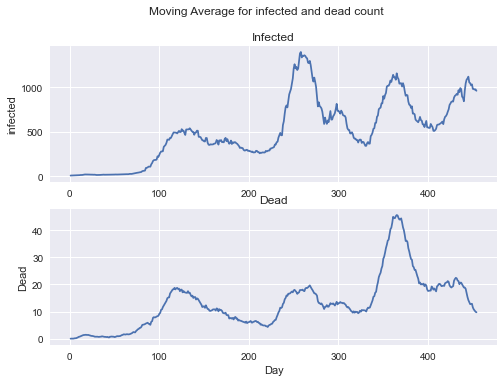

In [235]:
gap = 14
infected_results = []
count = 0
while count < len(infected_count_avg) - gap + 1:
    group = infected_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    infected_results.append(group_avg)
    count +=1

infected_day_month = []
for day in range(1, len(infected_results) + 1):
    infected_day_month.append(day)


dead_results = []
count = 0
while count < len(dead_count_avg) - gap + 1:
    group = dead_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    dead_results.append(group_avg)

    count +=1

dead_day_month = []
for day in range(1, len(dead_results) + 1):
    dead_day_month.append(day)

plt.style.use('seaborn')
fig, axs = plt.subplots(2)
fig.suptitle('Moving Average for infected and dead count')
axs[0].set_title('Infected')
axs[1].set_title('Dead')

    
# Visualizar gráfico de médias móveis
axs[0].set(ylabel='infected')
axs[0].plot(infected_day_month, infected_results)

# Visualizar gráfico de médias móveis
axs[1].set(xlabel='Day', ylabel='Dead')
axs[1].plot(dead_day_month, dead_results)
plt.show()

Gráfico 1: Médias móveis para infectados e óbitos

In [ ]:
infected_df = pd.DataFrame({'date': infected_day_month, 'avg': infected_results})
dead_df = pd.DataFrame({'date': dead_day_month, 'avg': dead_results})

In [ ]:
infected_df.tail()

In [ ]:
dead_df.tail()

<AxesSubplot:title={'center':'Infected'}>

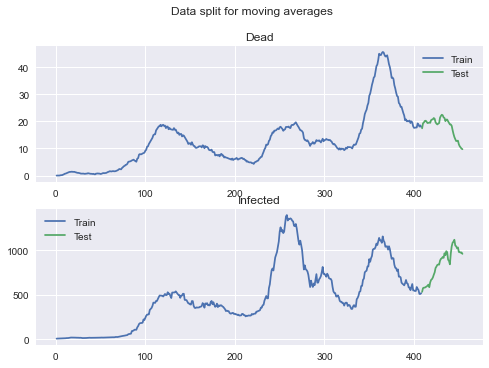

In [236]:
fig, axs = plt.subplots(2)
fig.suptitle('Data split for moving averages')
axs[0].set_title('Dead')
axs[1].set_title('Infected')
             
X = dead_df['date'].values
y = dead_df['avg'].values

train_length = int(len(dead_df)*0.9)
test_length = len(dead_df) - train_length

dead_X_train = X[0:train_length]
dead_y_train = y[0:train_length]

dead_X_test = X[train_length:len(dead_df)]
dead_y_test = y[train_length:len(dead_df)]

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train', ax=axs[0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test', ax=axs[0])


X = infected_df['date'].values
y = infected_df['avg'].values

train_length = int(len(infected_df)*0.9)
test_length = len(infected_df) - train_length

infected_X_train = X[0:train_length]
infected_y_train = y[0:train_length]

infected_X_test = X[train_length:len(infected_df)]
infected_y_test = y[train_length:len(infected_df)]

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train', ax=axs[1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test', ax=axs[1])

Grafico 2: Divisão de treino e teste

### Treinando os modelos iniciais

<AxesSubplot:>

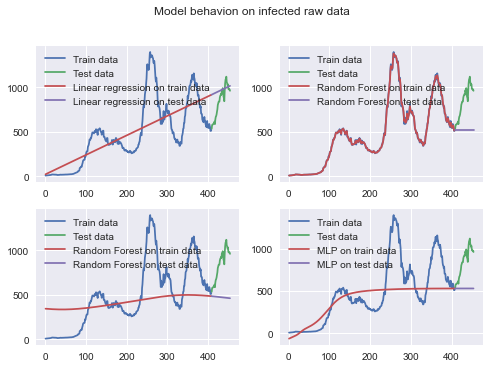

In [270]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(infected_X_train.reshape(-1, 1), infected_y_train)

predictions = lin_reg.predict(infected_X_test.reshape(-1, 1))
lin_mse = mean_squared_error(infected_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(infected_X_train.reshape(-1, 1), infected_y_train)
forest_predictions = forest_reg.predict(infected_X_test.reshape(-1, 1))

forest_mse = mean_squared_error(infected_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(infected_X_train.reshape(-1, 1), infected_y_train)
svr_preds = svr.predict(infected_X_test.reshape(-1, 1))
svr_mse = mean_squared_error(infected_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(infected_X_train.reshape(-1, 1), infected_y_train)
mlp_preds = mlp.predict(infected_X_test.reshape(-1, 1))
mlp_mse = mean_squared_error(infected_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=infected_X_train, y=lin_reg.predict(infected_X_train.reshape(-1, 1)), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=infected_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=infected_X_train, y=forest_reg.predict(infected_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=infected_X_test, y=forest_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=infected_X_train, y=svr.predict(infected_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=infected_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=infected_X_train, y=mlp.predict(infected_X_train.reshape(-1, 1)), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=infected_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


In [273]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, svr_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, mlp_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  -0.21150242399063868
R-2:  -0.21150242399063868
Absolute Error:  143.9849593717681
RMSE:  188.4213687022088
###########################
Random forest Scores
---------------------------
Score:  -3.6995764265815696
R-2:  -3.6995764265815696
Absolute Error:  329.26381987577713
RMSE:  371.105481154276
###########################
SVR
---------------------------
Score:  -4.837550041860695
R-2:  -4.837550041860695
Absolute Error:  373.6303546022264
RMSE:  413.602655807464
###########################
MLP
---------------------------
Score:  -3.432939695270499
R-2:  -3.432939695270499
Absolute Error:  317.20504955065593
RMSE:  360.4241825542098
---------------------------


<AxesSubplot:>

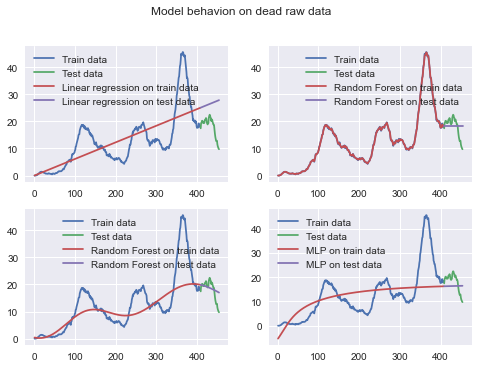

In [278]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on dead raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(dead_X_train.reshape(-1, 1), dead_y_train)

predictions = lin_reg.predict(dead_X_test.reshape(-1, 1))
lin_mse = mean_squared_error(dead_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(dead_X_train.reshape(-1, 1), dead_y_train)
forest_predictions = forest_reg.predict(dead_X_test.reshape(-1, 1))

forest_mse = mean_squared_error(dead_y_test, predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(dead_X_train.reshape(-1, 1), dead_y_train)
svr_preds = svr.predict(dead_X_test.reshape(-1, 1))
svr_mse = mean_squared_error(dead_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(dead_X_train.reshape(-1, 1), dead_y_train)
mlp_preds = mlp.predict(dead_X_test.reshape(-1, 1))
mlp_mse = mean_squared_error(dead_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=dead_X_train, y=lin_reg.predict(dead_X_train.reshape(-1, 1)), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=dead_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=dead_X_train, y=forest_reg.predict(dead_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=dead_X_test, y=forest_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=dead_X_train, y=svr.predict(dead_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=dead_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=dead_X_train, y=mlp.predict(dead_X_train.reshape(-1, 1)), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=dead_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


In [279]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, svr_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, mlp_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  -22.9305479817773
R-2:  -22.9305479817773
Absolute Error:  819.8941492994666
RMSE:  9.341966354078588
###########################
Random forest Scores
---------------------------
Score:  -23.405999998951067
R-2:  -23.405999998951067
Absolute Error:  828.1931055900621
RMSE:  9.341966354078588
###########################
SVR
---------------------------
Score:  -23.388939371872603
R-2:  -23.388939371872603
Absolute Error:  827.7322187564852
RMSE:  3.039781446074649
###########################
MLP
---------------------------
Score:  -23.506325609549748
R-2:  -23.506325609549748
Absolute Error:  829.9773449828048
RMSE:  4.040758556802266
---------------------------


### Escalonando os dados

In [280]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])
# infectados
transformed_infected_X_train = num_pipeline.fit_transform(infected_X_train.reshape(-1, 1))
transformed_infected_X_test = num_pipeline.fit_transform(infected_X_test.reshape(-1, 1))

transformed_infected_y_train = num_pipeline.fit_transform(infected_y_train.reshape(-1, 1))
transformed_infected_y_test = num_pipeline.fit_transform(infected_y_test.reshape(-1, 1))

# Óbitos
transformed_dead_X_train = num_pipeline.fit_transform(dead_X_train.reshape(-1, 1))
transformed_dead_X_test = num_pipeline.fit_transform(dead_X_test.reshape(-1, 1))

transformed_dead_y_train = num_pipeline.fit_transform(dead_y_train.reshape(-1, 1))
transformed_dead_y_test = num_pipeline.fit_transform(dead_y_test.reshape(-1, 1))

## Ajustando os parâmetros dos modelos

In [288]:
%%capture

# Linear regression
param_grid = [{'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]}]
infected_lin_grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_lin_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_lin_grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_lin_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)

# RandomForest
param_grid = [
    {
        'n_estimators': [10, 50, 100, 200, 500],
        'max_depth': [1, 2, 3, 4, 5],
    },
]
infected_forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_forest_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_forest_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)


# SVR
param_grid = [
    {
        'C': [2.0, 2.1, 2.2, 2.5, 2.7, 3.0, 4.0, 5.0, 50],
        'degree': [-1, 1, 1.5, 2, 3, 4, 5],
        'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7]
    },
]

infected_svr_grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_svr_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_svr_grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_svr_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)


# MLP
param_grid = [
    {
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 0.9],
        'max_iter': [200, 500, 800],
        'hidden_layer_sizes': [(100, ), (256, 128), (512, 256, 128), (1000, 500, 300)]
    },
]

infected_mlp_grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_mlp_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_mlp_grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_mlp_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)

In [289]:
print('Linear Regression')
print('Infected: ', infected_linear_grid_search.best_params_)
print('Dead: ', dead_linear_grid_search.best_params_)
print('---'*9)
print('Random Forest')
print('Infected: ', infected_forest_grid_search.best_params_)
print('Dead: ', dead_forest_grid_search.best_params_)
print('---'*9)
print('SVR')
print('Infected: ', infected_svr_grid_search.best_params_)
print('Dead: ', dead_svr_grid_search.best_params_)
print('---'*9)
print('MLP')
print('Infected: ', infected_mlp_grid_search.best_params_)
print('Dead: ', dead_mlp_grid_search.best_params_)
print('---'*9)

Linear Regression


NameError: name 'infected_linear_grid_search' is not defined

### Retreinando os modelos

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(transformed_infected_X_train, transformed_infected_y_train)

predictions = lin_reg.predict(transformed_infected_X_test)
lin_mse = mean_squared_error(transformed_infected_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(transformed_infected_X_train, transformed_infected_y_train)
forest_predictions = forest_reg.predict(transformed_infected_X_test)

forest_mse = mean_squared_error(transformed_infected_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(transformed_infected_X_train, transformed_infected_y_train)
svr_preds = svr.predict(transformed_infected_X_test)
svr_mse = mean_squared_error(transformed_infected_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(transformed_infected_X_train, transformed_infected_y_train)
mlp_preds = mlp.predict(transformed_infected_X_test)
mlp_mse = mean_squared_error(transformed_infected_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=transformed_infected_X_train, y=transformed_infected_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=transformed_infected_X_test, y=transformed_infected_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=transformed_infected_X_train, y=lin_reg.predict(transformed_infected_X_train), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=transformed_infected_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=transformed_infected_X_train, y=transformed_infected_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=transformed_infected_X_test, y=transformed_infected_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=transformed_infected_X_train, y=transformed_forest_reg.predict(transformed_infected_X_train), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=transformed_infected_X_test, y=transformed_forest_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=transformed_infected_X_train, y=transformed_infected_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=transformed_infected_X_test, y=transformed_infected_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=transformed_infected_X_train, y=svr.predict(transformed_infected_X_train), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=transformed_infected_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=transformed_infected_X_train, y=transformed_infected_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=transformed_infected_X_test, y=transformed_infected_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=transformed_infected_X_train, y=mlp.predict(transformed_infected_X_train), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=transformed_infected_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


In [ ]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, svr_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, mlp_preds))
print('Absolute Error: ', metrics.mean_absolute_error(y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(transformed_dead_X_train, transformed_dead_y_train)

predictions = lin_reg.predict(transformed_dead_X_test)
lin_mse = mean_squared_error(transformed_dead_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(transformed_dead_X_train, transformed_dead_y_train)
forest_predictions = forest_reg.predict(transformed_dead_X_test)

forest_mse = mean_squared_error(transformed_dead_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(transformed_dead_X_train, transformed_dead_y_train)
svr_preds = svr.predict(transformed_dead_X_test)
svr_mse = mean_squared_error(transformed_dead_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(transformed_dead_X_train, transformed_dead_y_train)
mlp_preds = mlp.predict(transformed_dead_X_test)
mlp_mse = mean_squared_error(transformed_dead_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=transformed_dead_X_test, y=transformed_dead_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=transformed_dead_X_train, y=lin_reg.predict(transformed_dead_X_train), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=transformed_dead_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=transformed_dead_X_test, y=transformed_dead_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_reg.predict(transformed_infected_X_train), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=transformed_dead_X_test, y=transformed_dead_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=transformed_dead_X_test, y=transformed_dead_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=transformed_dead_X_train, y=svr.predict(transformed_dead_X_train), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=transformed_dead_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=transformed_dead_X_test, y=transformed_dead_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=transformed_dead_X_train, y=mlp.predict(transformed_dead_X_train), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=transformed_dead_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


In [ ]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, svr_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(X_test.reshape(-1, 1), y_test))
print('R-2: ', metrics.r2_score(y_test, mlp_preds))
print('Absolute Error: ',metrics.mean_absolute_error(y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

Optou-se por particionar a data em colunas específicas para expandir a análise exploratória:

<AxesSubplot:>

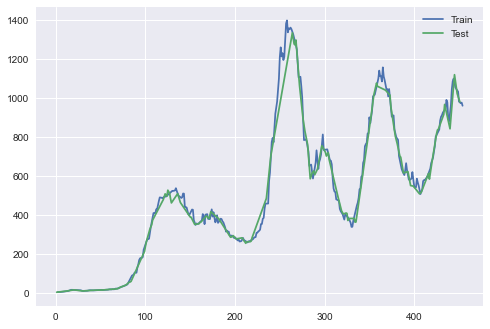

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    dead_df.date.values,
    dead_df['avg'].values
)

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=y_test, label='Test')

In [37]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std deviation: ', scores.std())

In [147]:
lin_reg = LinearRegression()
lin_reg.fit(X_train.reshape(-1, 1), y_train)

predictions = lin_reg.predict(X_test.reshape(-1, 1))
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

lin_reg_scores = cross_val_score(lin_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_reg_scores)

print(lin_rmse)
display_scores(lin_rmse_scores)

9.341966354078588
Scores:  [4.49944361 2.08654003 0.97863376 0.3254902  4.18010396 3.75149518
 2.8734873  1.32764628 3.11518906 5.58219343]
Mean:  2.8720222796243333
Std deviation:  1.600282339183326


<AxesSubplot:>

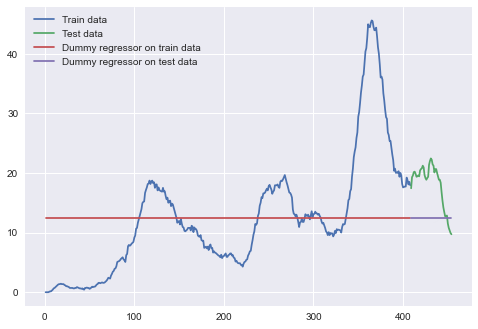

In [179]:
# sns.lineplot(x=X_train, y=y_train, label='Train')
# sns.lineplot(x=X_test, y=predictions.reshape(-1),
#              label='Linear regression with scaled data')
# Dummy
sns.lineplot(x=X_train, y=y_train, label='Train data')
sns.lineplot(x=X_test, y=y_test, label='Test data')
sns.lineplot(x=X_train, y=dr.predict(transformed_X_train), label='Dummy regressor on train data')
sns.lineplot(x=X_test, y=dr.predict(transformed_X_test), label='Dummy regressor on test data')



<AxesSubplot:>

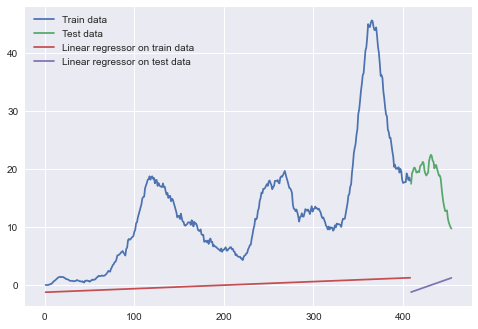

In [205]:

# # Linear
sns.lineplot(x=X_train, y=y_train, label='Train data')
sns.lineplot(x=X_test, y=y_test, label='Test data')
sns.lineplot(x=X_train, y=lin_reg.predict(transformed_X_train).reshape(-1), label='Linear regressor on train data')
sns.lineplot(x=X_test, y=lin_reg.predict(transformed_X_test).reshape(-1), label='Linear regressor on test data')


## Referências

<hr />

CURITIBA, Prefeitura Municipal de. **Endereços da Vigilância Sanitária Municipal**. 2021. Online, disponível em: <https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729> Último acesso em: 21/07/2021;

GUIZELINI, Dieval et al. Algoritmos Genéticos e média móvel para ajuste da curva de predição da infecção por SARS-Cov-2. In: Algoritmos Genéticos e média móvel para ajuste da curva de predição da infecção por SARS-Cov-2. [S. l.], 2020. Disponível em: https://www.bioinfo.ufpr.br/covid19/index.html. Acesso em: 22 jul. 2021.

HARRISON, Matt. Machine Learning: Guia de Referência Rápida. Novatec, 1˚ edição. 2020;

OLIVEIRA, Alcides Augusto Souto de. **Casos de COVID-19 em Curitiba**. Prefeitura de Curitiba - Dados abertos, 2021; Online: Disponível em: <https://www.curitiba.pr.gov.br/dadosabertos/busca/?pagina=2> Último acesso em: 21/07/2021;

RIZZATTI, Maurício et al. MAPEAMENTO DA COVID-19 POR MEIO DA DENSIDADE DE KERNEL. Metodologias e Aprendizado, [S. l.], v. 3, p. 44-53, 24 maio 2020. DOI https://doi/10.21166/metapre.v3i0.1312. Disponível em: https://publicacoes.ifc.edu.br/index.php/metapre/article/view/1312/1020. Acesso em: 22 jul. 2021.

